<a href="https://colab.research.google.com/github/ncsu-geoforall-lab/geomorphometry2025_workshop/blob/main/geomorphometry_2025_workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Workshop: Propagating DEM Uncertainty to Stream Extraction using GRASS

<a name="start"></a>
### Start GRASS and Create a New Project

First, we'll install GRASS:

In [24]:
!lsb_release -a

No LSB modules are available.
Distributor ID:	Pop
Description:	Pop!_OS 22.04 LTS
Release:	22.04
Codename:	jammy


In [25]:
!add-apt-repository -y ppa:ubuntugis/ubuntugis-unstable
!apt update
!apt-get install -y grass-core grass-dev

Error: must run as root
Reading package lists... Done
E: Could not open lock file /var/lib/apt/lists/lock - open (13: Permission denied)
E: Unable to lock directory /var/lib/apt/lists/
W: Problem unlinking the file /var/cache/apt/pkgcache.bin - RemoveCaches (13: Permission denied)
W: Problem unlinking the file /var/cache/apt/srcpkgcache.bin - RemoveCaches (13: Permission denied)
E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


In [1]:
!grass --version

GRASS GIS 8.5.0dev
Geographic Resources Analysis Support System (GRASS) is Copyright,
1999-2025 by the GRASS Development Team, and licensed under terms of the
GNU General Public License (GPL) version >=2.

This GRASS GIS 8.5.0dev release is coordinated and produced by
the GRASS Development Team with contributions from all over the world.

This program is distributed in the hope that it will be useful, but
WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the GNU
General Public License for more details.


Now, we can import GRASS's Python APIs, `grass.scripts` and `grass.jupyter` into our Python environment.

In [91]:
import sys
import subprocess
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, Image

# Ask GRASS where its Python packages are to be able to run it from the notebook
sys.path.append(
    subprocess.check_output(["grass", "--config", "python_path"], text=True).strip()
)
import grass.script as gs
import grass.jupyter as gj

With our packages imported, we can now create a new project called "geomorphometry_workshop". Projects are defined by a Coordinate Reference System (CRS). We can set the CRS from a georeferenced file (such as a Geotiff) or an EPSG string. Here, we use [EPSG 32632](https://epsg.io/32632), CRS WGS 84/UTM zone 32N (EPSG:32632).

In [3]:
from grass.exceptions import ScriptError
# Cleanly fail if the project already exists
try:
    gs.create_project("geomorphometry_workshop", epsg="32632")
except ScriptError as e:
    print(e)
    pass

except Exception as e:
    print("An unexpected error occurred:", e)


ERROR: Location <geomorphometry_workshop> already exists. Operation
       canceled.


SystemExit: 1

/home/coreywhite/Documents/GitHub/ncsu-geoforall-lab/geomorphometry2025_workshop/.venv/lib/python3.13/site-packages/IPython/core/interactiveshell.py:3675: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


We start a GRASS session in our new project.

In [92]:
gj.init("geomorphometry_workshop")

In [3]:
print(
    gs.read_command(
        "g.region", n=4780470, s=4774720, e=783130, w=777410, res=10, flags="pa"
    )
)

from ipyleaflet import ImageService, WMSLayer, Marker
from ipyleaflet.projections import projections
import xyzservices
# im = ImageService(
#     url="https://landsat.arcgis.com/arcgis/rest/services/Landsat/PS/ImageServer",
#     rendering_rule={"rasterFunction": "Pansharpened Enhanced with DRA"},
#     format="jpgpng",
#     attribution="United States Geological Survey (USGS), National Aeronautics and Space Administration (NASA)",
# )

tinitaly_wms = WMSLayer(
    name="TINItaly_1.1 HSV (WMS)",
    url="http://tinitaly.pi.ingv.it/TINItaly_1_1/wms?service=WMS",
    layers="TINItaly_1.1:tinitaly_hsv",
    format="image/png",
    transparent=True,
    attribution="HSV Elevation Data © 2023 TINItaly 1.1",
)

tinitaly_slope = WMSLayer(
    name="TINItaly_1.1 Slope (WMS)",
    url="http://tinitaly.pi.ingv.it/TINItaly_1_1/wms?service=WMS",
    layers="TINItaly_1.1:tinitaly_slope",
    format="image/png",
    transparent=True,
    attribution="Slope Data © 2023 TINItaly 1.1",
)

nasa_wms = WMSLayer(
    name="NASA SRTM RAMP2 TOPO (WMS)",
    url="https://neo.gsfc.nasa.gov/wms/wms?service=WMS",
    layers="SRTM_RAMP2_TOPO",
    format="image/png",
    transparent=True,
    styles="rgb",
    attribution="SRTM RAMP2 TOPO © 2025 NASA ",
)

perugia = Marker(
    name="Perugia (Marker)",
    location=(43.11203, 12.38914),
    draggable=False,
    title="Perugia",
    alt="Perugia",
    # icon="fa-flag",
)

# m.map.add(im)
nasa_basemap = "NASAGIBS BlueMarble"
# print("Basemap: ", xyzservices.providers.query_name(nasa_basemap))
m = gj.InteractiveMap(height=600, width=800, tiles=nasa_basemap, use_region=True)
m.map.add(tinitaly_wms)
m.map.add(tinitaly_slope)
m.map.add(nasa_wms)
m.map.add(perugia)
m.add_layer_control()
m.map.zoom = 6
m.map.center = (43.11203, 12.38914)
display(m.show())

projection: 1 (UTM)
zone:       32
datum:      wgs84
ellipsoid:  wgs84
north:      4780470
south:      4774720
west:       777410
east:       783130
nsres:      10
ewres:      10
rows:       575
cols:       572
cells:      328900



Map(center=[43.11203, 12.38914], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', '…

Now we can import our DEM. We will use the [r.import](https://grass.osgeo.org/manuals/grass85/r.import.html) command to import a DEM file. The DEM file is a [Cloud Optimized GeoTIFF (COG)](https://cogeo.org/), and we will specify the output name as "dem". *r.import* will automatically reproject the DEM to the project's CRS.

In [40]:
gs.run_command(
    "r.import",
    input="https://storage.googleapis.com/geomorphometry/w47575_s10.cog.tif",
    output="dem",
    title="TINItaly DEM 10m",
    resample="bilinear",
    resolution="value",
    resolution_value=10, # 10m
    overwrite=True,
)
print(gs.read_command("g.region", raster="dem", flags="pa"))

projection: 1 (UTM)
zone:       32
datum:      wgs84
ellipsoid:  wgs84
north:      4802080
south:      4747950
west:       748120
east:       802260
nsres:      10
ewres:      10
rows:       5413
cols:       5414
cells:      29305982



Alternatively, set region with g.region to the approximate bounds of a watershed near Perugia that opens into a flat plain. Also, set the resolution to 10m (same as TINItaly).

In [93]:
print(gs.read_command("g.region", raster="dem", flags="pa"))

projection: 1 (UTM)
zone:       32
datum:      wgs84
ellipsoid:  wgs84
north:      4802080
south:      4747950
west:       748120
east:       802260
nsres:      10
ewres:      10
rows:       5413
cols:       5414
cells:      29305982



In [94]:
print(gs.run_command("r.info", map="dem"))

 +----------------------------------------------------------------------------+
 | Map:      dem                            Date: Fri Apr 25 12:48:54 2025    |
 | Mapset:   PERMANENT                      Login of Creator: coreywhite      |
 | Project:  geomorphometry_workshop                                          |
 | DataBase: /home/coreywhite/Documents/GitHub/ncsu-geoforall-lab/geomorphome |
 | Title:                                                                     |
 | Timestamp: none                                                            |
 |----------------------------------------------------------------------------|
 |                                                                            |
 |   Type of Map:  raster               Number of Categories: 0               |
 |   Data Type:    FCELL                Semantic label: (none)                |
 |   Rows:         5413                                                       |
 |   Columns:      5414                 

In [95]:
print(gs.run_command("r.univar", map="dem", flags="e"))

total null and non-null cells: 29305982
total null cells: 4216001

Of the non-null cells:
----------------------
n: 25089981
minimum: 144.876
maximum: 1290.34
range: 1145.47
mean: 355.905
mean of absolute values: 355.905
standard deviation: 146.431
variance: 21442
variation coefficient: 41.1432 %
sum: 8929643815.45746
1st quartile: 244.619
median (odd number of cells): 321.518
3rd quartile: 446.525
90th percentile: 554.304
None


In [8]:


gs.run_command("r.colors", map="dem", color="elevation", flags="e")

m = gj.InteractiveMap(use_region=True)
m.add_raster("dem", opacity=0.5)
m.add_layer_control()
display(m.show())

Map(center=[0.0, 0.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

TODO: display this data and look at a history

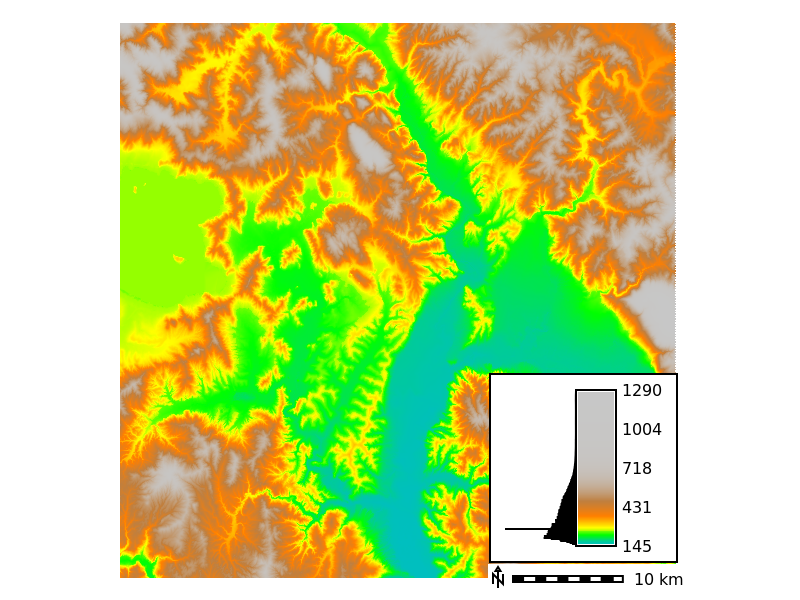

In [96]:
m = gj.Map(use_region=True, height=600, width=800)
m.d_rast(map="dem")
m.d_legend(raster="dem", flags="bds", at="9,35,72,77", fontsize=16)
m.d_barscale(at="61,6", fontsize=16, flags="n")
m.show()

projection: 1 (UTM)
zone:       32
datum:      wgs84
ellipsoid:  wgs84
north:      4802080
south:      4747950
west:       748120
east:       802360
nsres:      10
ewres:      10
rows:       5413
cols:       5424
cells:      29360112


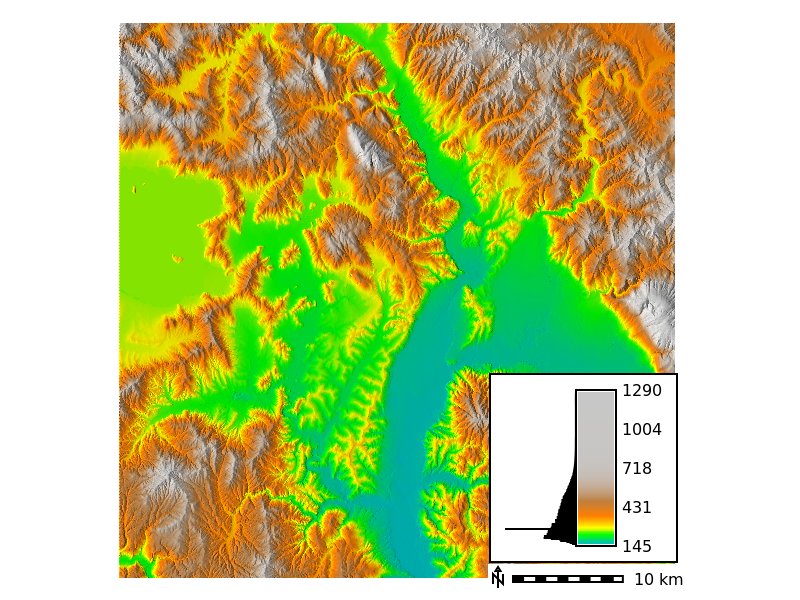

In [97]:
gs.run_command("r.relief", input="dem", output="relief")
region = gs.region()
gs.run_command("g.region", n=region.n, s=region.s, e=region.e + 100, w=region.w, flags="pa")
m = gj.Map(use_region=True, height=600, width=800)
m.d_shade(shade="relief", color="dem", brighten=30)
m.d_legend(raster="dem", flags="bds", at="9,35,72,77", fontsize=16)
m.d_barscale(at="61,6", fontsize=16, flags="n")
m.show()


Sample Points

TODO: Statified sampling by landcover to mimic Lidar? Like lower frequency in heavily vegetated areas and none in water/buildings?

In [98]:
print(
    gs.read_command(
        "g.region", n=4780470, s=4774720, e=783130, w=777410, res=10, flags="pa"
    )
)
gs.run_command("r.random", input="dem", vector="elevrand", n=10000, flags="s")

projection: 1 (UTM)
zone:       32
datum:      wgs84
ellipsoid:  wgs84
north:      4780470
south:      4774720
west:       777410
east:       783130
nsres:      10
ewres:      10
rows:       575
cols:       572
cells:      328900



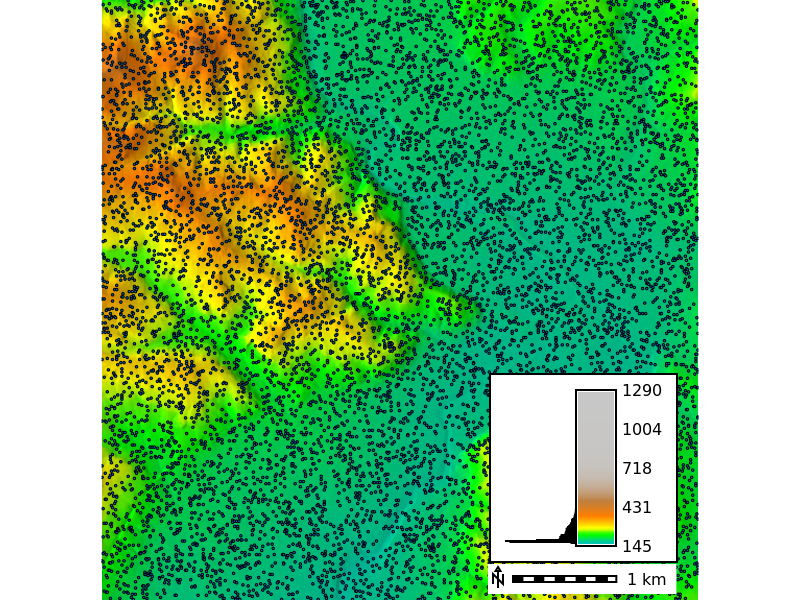

In [99]:
m = gj.Map(use_region=True, height=600, width=800)
m.d_shade(shade="relief", color="dem", brighten=30)
m.d_vect(map="elevrand", color="black", icon="basic/point")
m.d_legend(raster="dem", flags="bds", at="9,35,72,77", fontsize=16)
m.d_barscale(at="61,6", fontsize=16, flags="n")
m.show()



In [100]:
gs.run_command("r.slope.aspect", elevation="dem", slope="slope", aspect="aspect", overwrite=True)

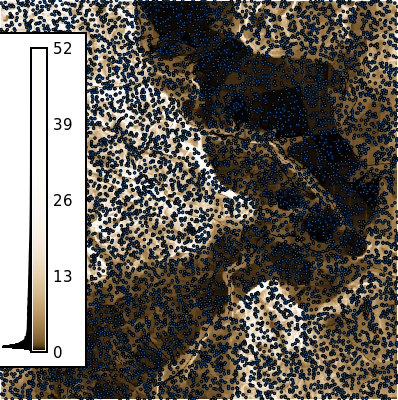

In [101]:
gs.run_command("r.colors", map="slope", color="sepia", flags="e")

m = gj.Map(use_region=True)
m.d_rast(map="slope")
m.d_vect(map="elevrand", color="black", icon="basic/point")
m.d_legend(raster="slope", flags="bds")
m.show()

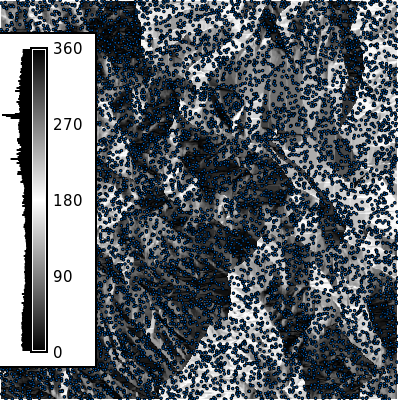

In [102]:
m = gj.Map(use_region=True)
m.d_rast(map="aspect")
m.d_vect(map="elevrand", color="black", icon="basic/point")
m.d_legend(raster="aspect", flags="bds")
m.show()

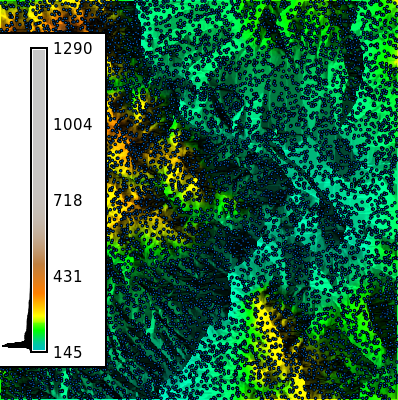

In [103]:
m = gj.Map(use_region=True)
m.d_shade(shade="aspect", color="dem", brighten=30)
m.d_vect(map="elevrand", color="black", icon="basic/point")
m.d_legend(raster="dem", flags="bds")
m.show()

## Move to R for Kriging

Set up R.

Load rpy2 extension. rpy2 is an interface to R running embedded in a Python process allowing up to continue operating in our current Python session but cells in R.

In [10]:
%load_ext rpy2.ipython

Now, we can use the %%R cell magic. When this cell is interpreted, it's contents will be sent to R. We could also use line magic now with %R which would only send the line to R.

In [11]:
%%R
system("apt-get install r-cran-sf")

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


In [44]:
%%R
system("apt-get install r-cran-gstat r-cran-terra r-cran-devtools r-cran-irkernel")

We also need the rgrass package which is distributed on GitHub.

In [12]:
%%R
R.version.string

[1] "R version 4.5.0 (2025-04-11)"


Load libraries.
- Tell R to use the system packages

In [14]:
%%R

library(sf)
print(packageDescription("sf"))
library(gstat)
print(packageDescription("gstat"))
library(terra)
print(packageDescription("terra"))
library(rgrass)
print(packageDescription("rgrass"))


Package: sf
Version: 1.0-6
Title: Simple Features for R
Authors@R: c(person(given = "Edzer", family = "Pebesma", role =
        c("aut", "cre"), email = "edzer.pebesma@uni-muenster.de",
        comment = c(ORCID = "0000-0001-8049-7069")), person(given =
        "Roger", family = "Bivand", role = "ctb", comment = c(ORCID =
        "0000-0003-2392-6140")), person(given = "Etienne", family =
        "Racine", role = "ctb"), person(given = "Michael", family =
        "Sumner", role = "ctb"), person(given = "Ian", family = "Cook",
        role = "ctb"), person(given = "Tim", family = "Keitt", role =
        "ctb"), person(given = "Robin", family = "Lovelace", role =
        "ctb"), person(given = "Hadley", family = "Wickham", role =
        "ctb"), person(given = "Jeroen", family = "Ooms", role = "ctb",
        comment = c(ORCID = "0000-0002-4035-0289")), person(given =
        "Kirill", family = "M\u00fcller", role = "ctb"), person(given =
        "Thomas Lin", family = "Pedersen", role = 

Use readVECT from rgrass to turn the random elevation points into a [SpatVector](https://rdrr.io/cran/terra/man/SpatVector-class.html), the terra vector class.

In [104]:
%%R

# Set GRASS region
rgrass::execGRASS("g.region", n="4780470", s="4774720", e="783130", w="777410", flags = c("p","a"))

# Read vector elevation points from GRASS
elevrand <- rgrass::read_VECT("elevrand")
# Ensure the directory exists
# if (!dir.exists("cgsSim/data")) {
#   dir.create("cgsSim/data", recursive = TRUE)
# }

# saveRDS(elevrand, file = "cgsSim/data/elevrand.rds")


projection: 1 (UTM)
zone:       32
datum:      wgs84
ellipsoid:  wgs84
north:      4780470
south:      4774720
west:       777410
east:       783130
nsres:      10
ewres:      10
rows:       575
cols:       572
cells:      328900
Exporting 10000 features...
   0   6  12  18  24  30  36  42  48  54  60  66  72  78  84  90  96v.out.ogr complete. 10000 features (Point type) written to <elevrand> (GPKG
format).


In [121]:
%%R

coords <- terra::geom(elevrand)[, c("x", "y")]
dists <- as.matrix(dist(coords))
max_dist <- max(dists)

# Best practice
# Default cutoff is 0.5 but this is too small for our data
cutoff <- 0.75 * max_dist
width <- cutoff / 15
print(paste("Using cutoff:", cutoff, "and width:", width))

[1] "Using cutoff: 5982.35843961226 and width: 398.82389597415"


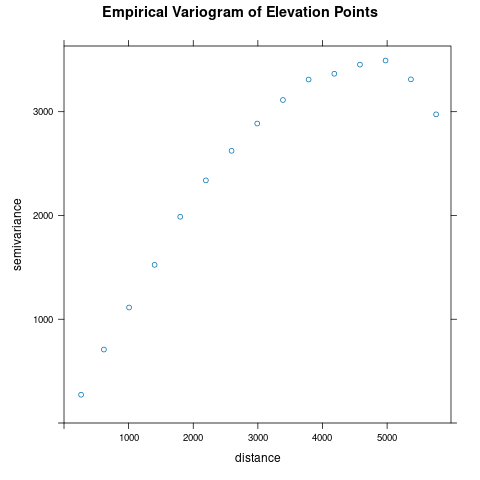

In [122]:
%%R
# Convert to sf-style data frame for gstat
elev_df <- terra::as.data.frame(elevrand, geom = "XY")
# saveRDS(elev_df, file = "cgsSim/data/dataframe.rds")
g <- gstat::gstat(formula = value ~ 1, locations = ~x + y, data = elev_df)
# saveRDS(g, file = "cgsSim/data/gstat.rds")

vg <- gstat::variogram(g, cutoff = cutoff, width = width)
# saveRDS(vg, file = "cgsSim/data/variorgram.rds")

plot(vg, main = "Empirical Variogram of Elevation Points")

In [123]:
%%R
# Load the cgsSim package
devtools::load_all("cgsSim/")

# Fit kappa
fit_kappa <- optimize_kappa(vg)
fit_kappa

ℹ Loading cgsSim


$model
  model     psill    range     kappa
1   Nug  117.0056    0.000 0.0000000
2   Mat 3734.3335 1528.713 0.9176489

$kappa
[1] 0.9176489

$SSErr
[1] 40079.61



TypeError: ZMQDisplayPublisher.publish() got an unexpected keyword argument 'source'

In [ ]:
%%R
# Load the cgsSim package
devtools::load_all("cgsSim/")

# Fit variogram automatically
fit_result <- auto_variogram_fit(elev_df, cutoff = cutoff, width = width, kappa = fit_kappa$kappa)


ℹ Loading cgsSim


[1] 231.8671
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]


In [ ]:
%%R

saveRDS(fit_result$vgm_model, file = "cgsSim/data/vgm_model.rds")

head(fit_result)

$psill
psill_start 
   1282.026 

$range
range_start 
   5984.591 

$nugget
nugget_start 
    25.64051 

$kappa
[1] 0.7017462

$mse
[1] 56.00105

$vgm_model
  model      psill    range     kappa
1   Nug   25.64051    0.000 0.0000000
2   Mat 1282.02566 5984.591 0.7017462



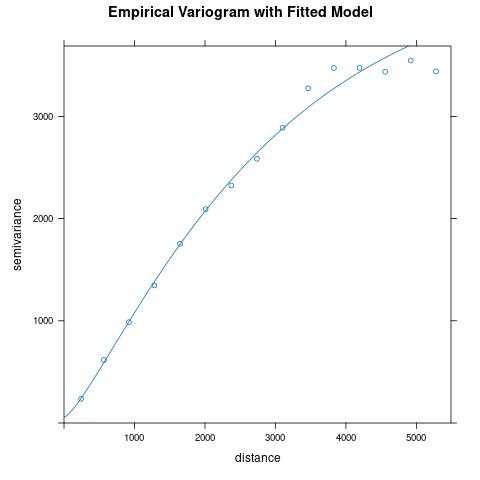

In [90]:
%%R
# devtools::load_all("cgsSim/")
# vfit <- gstat::fit.variogram(vg, model = vgm_model, fit.kappa = TRUE)
# Optimize the kappa parameter
# f = function(x) attr(m.fit <<- fit.variogram(vg, model = vgm(,"Mat",nugget=NA,kappa=x)),"SSErr")
# result <- optimize(f, c(0.1, 5))
# print(result$minimum)
# vfit <- gstat::fit.variogram(vg, model = fit_result$vgm_model, fit.kappa = FALSE)
# plot(vg, model = vfit, main = "Empirical Variogram with Fitted Model")
plot_auto_variogram(vg, fit_result$vgm_model)

In [ ]:
%%R
devtools::load_all("cgsSim/")
# pts <- prepare_pts(elev_df)
# g <- gstat::gstat(formula = value ~ 1, locations = ~ x + y, data = pts)
# vg <- gstat::variogram(g, cutoff = cutoff, width = width)


# vfit <- gstat::fit.variogram(vg, model = fit_result$vgm_model, fit.kappa = FALSE)
vfit <- gstat::fit.variogram(vg, model = vgm_model, fit.kappa = FALSE)
# Create 10m resolution grid for prediction
grid_ext <- terra::ext(elevrand)
grid_res <- 10

xy <- expand.grid(
  x = seq(grid_ext[1], grid_ext[2], by = grid_res),
  y = seq(grid_ext[3], grid_ext[4], by = grid_res)
)

# Convert to sf POINT geometry
# xy_sf <- sf::st_as_sf(xy, coords = c("x", "y"), crs = 32633)

run_sim(
  elev_df,
  fitmodel = vfit,
  nsim = 10,
  newdata=xy,
  nmin = 10,
  nmax = 40,
  distmax = cutoff,
)

ℹ Loading cgsSim


Exception ignored from cffi callback <function _processevents at 0x78ffae2b3240>:
Traceback (most recent call last):
  File "/home/coreywhite/Documents/GitHub/ncsu-geoforall-lab/geomorphometry2025_workshop/.venv/lib/python3.13/site-packages/rpy2/rinterface_lib/callbacks.py", line 283, in _processevents
    @ffi_proxy.callback(ffi_proxy._processevents_def,
KeyboardInterrupt: 


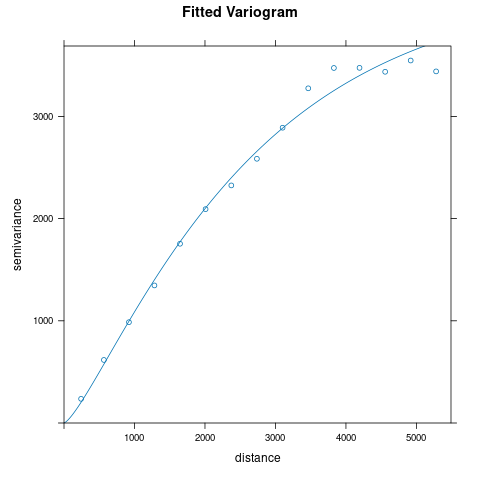

In [96]:
%%R

# Optimize the kappa parameter
f = function(x) attr(m.fit <<- fit.variogram(vg, vgm(,"Mat",nugget=NA,kappa=x)),"SSErr")
result <- optimize(f, c(0.1, 1.2))
vfit <- gstat::fit.variogram(vg, model = gstat::vgm(model = "Mat", kappa = result$minimum), fit.kappa = FALSE)

# Plot variogram and fitted model
plot(vg, model = vfit, main = "Fitted Variogram")

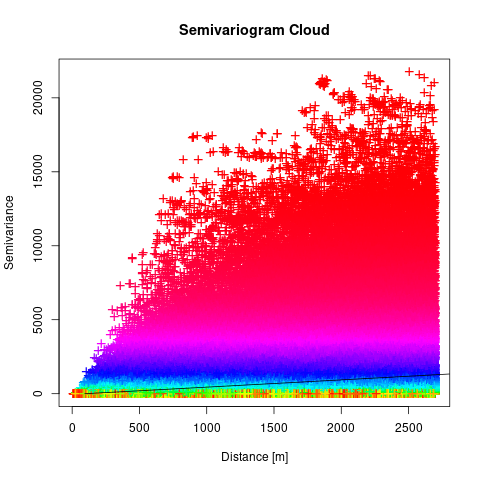

In [109]:
%%R
vc <- variogram(g, cloud=TRUE)

# Plot
plot(vc$dist, vc$gamma, pch="+", cex=1.5, xlab="Distance [m]", ylab="Semivariance", main="Semivariogram Cloud", col = rainbow(length(vc$gamma))[rank(vc$gamma)])
points(vfit[,2:3], type= "l", col='black')

This works in CoLab but not locally at the moment.

In [140]:
%%R

# Objective function: SSErr for each kappa
fit_variogram_sserr <- function(kappa) {
  base::attr(gstat::fit.variogram(vg, gstat::vgm(model = "Mat", kappa = kappa)), "SSErr")
}

# Range of kappa values to try
kappa_vals <- base::seq(0.1, 5, by = 0.1)

# # Compute SSErr for each value
sserr_vals <- base::sapply(kappa_vals, fit_variogram_sserr)

# # Optimize for best kappa
opt_result <- optimize(fit_variogram_sserr, c(0.1, 5))

best_kappa <- opt_result$minimum
best_sserr <- opt_result$objective

# # Plot SSErr vs. kappa
# plot(kappa_vals, sserr_vals, type = "b", pch = 16,
#      xlab = expression(kappa), ylab = "Sum of Squared Errors",
#      main = "SSErr vs. Matérn Smoothness (kappa)")

# # Add vertical line at best kappa
# abline(v = best_kappa, col = "grey", lty = 2)

# # Label the optimal point
# text(x = best_kappa, y = best_sserr, labels = paste0("kappa = ", round(best_kappa, 3)),
#      pos = 3, offset = 5, col = "blue")

TypeError: ZMQDisplayPublisher.publish() got an unexpected keyword argument 'source'

In [141]:
%%R

# Create 10m resolution grid for prediction
grid_ext <- terra::ext(elevrand)
grid_res <- 10

xy <- expand.grid(
  x = seq(grid_ext[1], grid_ext[2], by = grid_res),
  y = seq(grid_ext[3], grid_ext[4], by = grid_res)
)

# Convert to sf POINT geometry
xy_sf <- sf::st_as_sf(xy, coords = c("x", "y"))


# Recreate gstat object using sf
g <- gstat::gstat(
  formula = value ~ 1,
  data = elev_df,
  model = vfit,
  locations=~x+y
)


In [72]:
%%R
g <- gstat::gstat(
  formula = value ~ 1,
  data = elev_df,
  model = vfit,
  locations = ~x + y,
  nmin=10, 
  nmax=250,
  maxdist=400
)
# Number of SGS realizations
N.sim <- 4

# Output file prefix
output_prefix <- "sgs_sim"

raster_list <- list()

# Run SGS simulations
for (i in 1:N.sim) {
  cat("Simulating realization", i, "...\n")
  
  # Perform simulation
  sim <- predict(g, newdata = xy_sf, nsim = 1, debug.level = -1)
  
  # Extract the simulated values
  sim_values <- sim$sim1
  
  # Add simulated values to the grid
  xy_sf$sim <- sim_values
  
  # Convert to SpatRaster
  sim_rast <- terra::rast(xy_sf, crs = terra::crs(elevrand))
  
  # Rename layer
  names(sim_rast) <- paste0("sim_", i)
  
  # Save to GRASS raster
  out_file <- paste0(output_prefix, "_", i)
  rgrass::write_RAST(sim_rast, out_file)
  
  # Store in list
  raster_list[[i]] <- sim_rast
}

# Stack all results if needed
r_stack <- terra::rast(raster_list)

# Plot one realization
terra::plot(r_stack[[1]])

Simulating realization 1 ...
drawing 1 GLS realisation of beta...
[using conditional Gaussian simulation]
100% done
Error: [writeRaster] there are no cell values
In addition: There were 50 or more warnings (use warnings() to see the first 50)
Error: [writeRaster] there are no cell values


RInterpreterError: Failed to parse and evaluate line 'g <- gstat::gstat(\n  formula = value ~ 1,\n  data = elev_df,\n  model = vfit,\n  locations = ~x + y,\n  nmin=10, \n  nmax=250\n)\n# Number of SGS realizations\nN.sim <- 4\n\n# Output file prefix\noutput_prefix <- "sgs_sim"\n\nraster_list <- list()\n\n# Run SGS simulations\nfor (i in 1:N.sim) {\n  cat("Simulating realization", i, "...\\n")\n\n  # Perform simulation\n  sim <- predict(g, newdata = xy_sf, nsim = 1, debug.level = -1)\n\n  # Extract the simulated values\n  sim_values <- sim$sim1\n\n  # Add simulated values to the grid\n  xy_sf$sim <- sim_values\n\n  # Convert to SpatRaster\n  sim_rast <- terra::rast(xy_sf, crs = terra::crs(elevrand))\n\n  # Rename layer\n  names(sim_rast) <- paste0("sim_", i)\n\n  # Save to GRASS raster\n  out_file <- paste0(output_prefix, "_", i)\n  rgrass::write_RAST(sim_rast, out_file)\n\n  # Store in list\n  raster_list[[i]] <- sim_rast\n}\n\n# Stack all results if needed\nr_stack <- terra::rast(raster_list)\n\n# Plot one realization\nterra::plot(r_stack[[1]])\n'.
R error message: 'Error: [writeRaster] there are no cell values'
R stdout:
Error: [writeRaster] there are no cell values
In addition: There were 50 or more warnings (use warnings() to see the first 50)

In [23]:
%%R
# Stack all results if needed
r_stack <- terra::rast(raster_list)

# Plot one realization
terra::plot(r_stack)

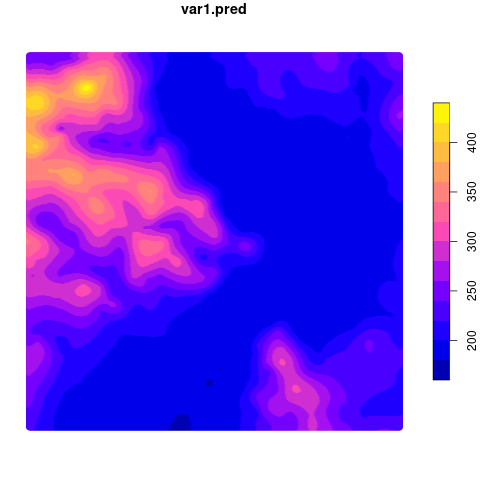

In [28]:
%%R

z_sf <- st_as_sf(z, coords = c("x", "y"), crs = crs(elevrand))

plot(z_sf["var1.pred"])

Run the stochastic simulation n times

Calculate the mean and standard deviation of the simulatate surfaces

In [13]:
%%R

execGRASS("g.list", type="raster", pattern="sgs_sim_*", output="tmp_list_simulated.txt")
execGRASS("r.series", file="tmp_list_simulated.txt", output="simulated_mean", method="average")
execGRASS("r.series", file="tmp_list_simulated.txt", output="simulated_std", method="stddev")

   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100


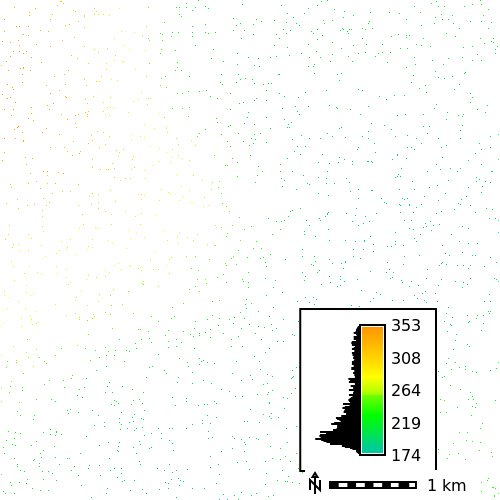

In [26]:
m = gj.Map(use_region=True, height=500, width=500)
m.d_rast(map="simulated_mean")
m.d_legend(raster="simulated_mean", flags="bds", at="9,35,72,77", fontsize=16)
m.d_barscale(at="61,6", fontsize=16, flags="n")
m.show()

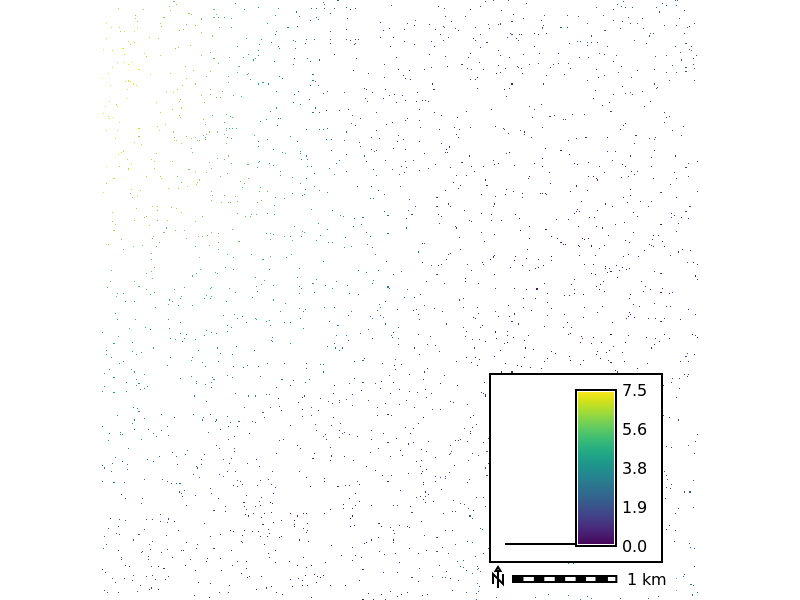

In [18]:
m = gj.Map(use_region=True, height=600, width=800)
m.d_rast(map="simulated_mean")
m.d_legend(raster="simulated_std", flags="bds", at="9,35,72,77", fontsize=16)
m.d_barscale(at="61,6", fontsize=16, flags="n")
m.show()

Generate streams for each DEM

In [16]:
%%R
N.sim <- 10
for(i in 1:N.sim) {execGRASS("r.watershed", elevation=paste("sgs_sim_", i, sep=""),
 threshold=10000, stream=paste("stream_", i, sep=""), flags=c("quiet"))}

TypeError: ZMQDisplayPublisher.publish() got an unexpected keyword argument 'source'

Calculate the probablity and error

In [19]:
%%R
execGRASS("g.list", type="raster", pattern="stream*", output="tmp_list_stream.txt")
execGRASS("r.series", file="tmp_list_stream.txt", output="count", method="count")
execGRASS("r.mapcalc", expression=paste("prob = float(count)/", N.sim))
execGRASS("r.mapcalc", expression="error = -prob * log(prob) - (1-prob)* log(1-prob)")

   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100


In [21]:
%%bash

r.colors simulated_mean rast=dem
r.colors sgs_sim_10 rast=dem
r.colors simulated_std co=bcyr -e
r.colors aspect_10 co=aspect
r.slope.aspect simulated_mean slo=slp_mean asp=asp_mean
r.slope.aspect sgs_sim_10 slo=slp_10 asp=asp_10
r.mapcalc "diff_spline_gsim = dem - simulated_mean"
r.colors diff_spline_gsim co=differences

Color table for raster map <simulated_mean> set to 'dem'
Color table for raster map <sgs_sim_10> set to 'dem'
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
Color table for raster map <simulated_std> set to 'bcyr'
ERROR: Raster map <aspect_10> not found
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
Aspect raster map <asp_mean> complete
Slope raster map <slp_mean> complete
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
Aspect raster map <asp_10> complete
Slope raster map <slp_10> complete
Color table for raster map <diff_spline_gsim> set to 'differences'


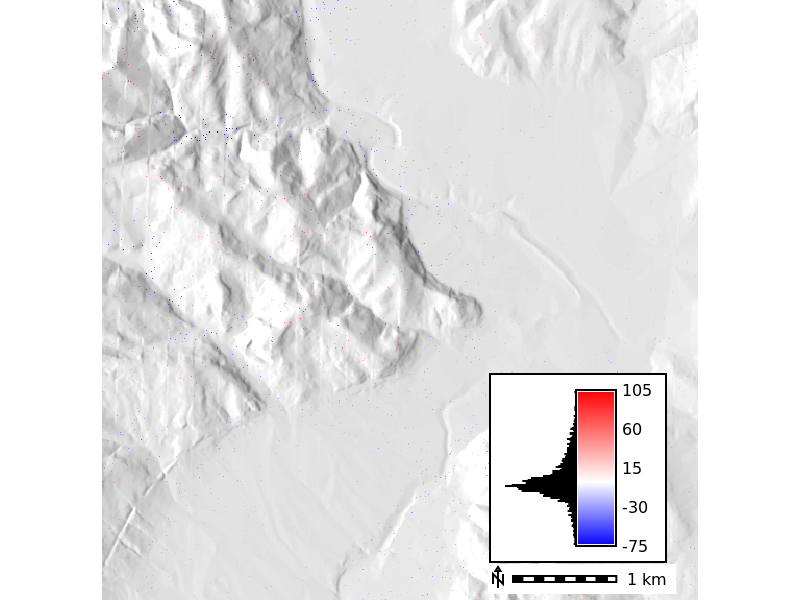

In [28]:
m = gj.Map(use_region=True, height=600, width=800)
m.d_shade(shade="relief", color="diff_spline_gsim", brighten=30)
m.d_legend(raster="diff_spline_gsim", flags="bds", at="9,35,72,77", fontsize=16)
m.d_barscale(at="61,6", fontsize=16, flags="n")
m.show()

Checking GDAL data type and nodata value...
   2   5   8  11  14  17  20  23  26  29  32  35  38  41  44  47  50  53  56  59  62  65  68  71  74  77  80  83  86  89  92  95  98 100
Using GDAL data type <Float32>
Exporting raster data to RRASTER format...
   2   5   8  11  14  17  20  23  26  29  32  35  38  41  44  47  50  53  56  59  62  65  68  71  74  77  80  83  86  89  92  95  98 100
r.out.gdal complete. File </tmp/Rtmp8OOieZ/file1ce84e1f9a8a.grd> created.


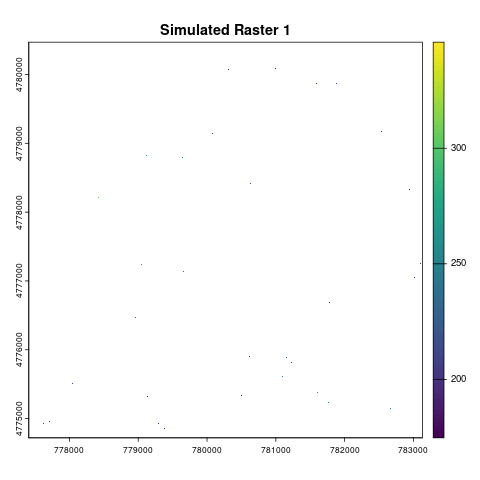

In [30]:
%%R
sgs_sim_1 <- rgrass::read_RAST("sgs_sim_1")
plot(sgs_sim_1, main = "Simulated Raster 1")

Original Workflow:

https://github.com/ncsu-geoforall-lab/GIS714-assignments/blob/main/Surface_Water_Simulations/WaterSim-Geostatistical-Simulations.ipynb

TUTORIAL Option:

https://geobgu.xyz/r/spatial-interpolation-of-point-data.html